<h1 align="center">Eleven key measures for monitoring general practice clinical activity during COVID-19 using federated analytics on 53 million adults’ primary care records through OpenSAFELY </h1>

**This notebook accompanies [this paper (add link)](), describing trends and variation in clinical activity codes using a set of key measures indicative of overall activity to evaluate NHS service restoration throughout the COVID-19 pandemic.**

The aim of the OpenSAFELY SRO is to describe trends and variation in clinical activity codes to evaluate NHS service restoration during the COVID-19 pandemic.

The purpose of this notebook is to provide a set of key GP measures at the practice level, that are indicative of changes in overall activity during the pandemic. For each of these measures we provide a link to the codelist containing all the codes used for that measure, a description of what the measure is and a brief overview of why the measure is important. We also highlight any caveats, where there are any, for each measure.  

Monthly rates of recorded activity are displayed as practice level decile charts to show both the general trend and practice level variation in activity changes. Accompanying each chart is a summary of the most commonly recorded SNOMED codes for each measure.

For each measure we also indicate the number of unique patients recorded as having at least one event indicated by the measure as well as the total number of events since January 2019.
A summary of the number of events for each measure is produced and monthly rates of recorded activity for each measure is plotted as a decile chart.

For each measure, we also median activity rate in April 2019 (baseline) and the percentage change from this median in April 2020 (time of the 1st national lockdown) and April 2021. These changes are used to give an overall classification of activity change as described in the box below.

* No change: no change from baseline in both April 2020 and April 2021.
* Increase: an increase from baseline in either April 2020 or April 2021.
* Sustained drop: a drop from baseline of >15% in April 2020 which **has not** returned to within 15% of the baseline by April 2021.
* Recovery: a drop of >15% from baseline in April 2020 which **has** returned to within 15% of the baseline by April 2021.

The following key measures are provided:

<ul id="docNav">
    <li> <a href="#systolic_bp">Blood Pressure Monitoring</a>
    <li> <a href="#qrisk2">Cardiovascular Disease 10 Year Risk Assessment</a>
    <li> <a href="#cholesterol">Cholesterol Testing</a>
    <li> <a href="#ALT">Liver Function Testing - Alanine Transferaminase (ALT)</a>
    <li> <a href="#serum_tsh">Thyroid Testing</a>
    <li> <a href="#rbc_fbc">Full Blood Count - Red Blood Cell (RBC) Testing</a>
    <li> <a href="#hba1c">Glycated Haemoglobin A1c Level (HbA1c)</a>
    <li> <a href="#serum_sodium">Renal Function Assessment - Sodium Testing</a>
    <li> <a href="#asthma">Asthma Reviews</a>
    <li> <a href="#copd">Chronic Obstrutive Pulmonary Disease (COPD) Reviews</a>
    <li> <a href="#med_review">Medication Review</a>
</ul>


In [63]:
from IPython.display import HTML
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utilities import *
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline
%config InlineBackend.figure_format='png'


In [64]:
def deciles_chart(
    df,
    period_column=None,
    column=None,
    title="",
    ylabel="",
    interactive=True,
    width=800,
    height=400,
):
    """period_column must be dates / datetimes"""
    
    df = compute_deciles(df, period_column, column, False)
  
    if interactive:

        fig = go.Figure()

        linestyles = {
            "decile": {"color": "blue", "dash": "dash"},
            "median": {"color": "blue", "dash": "solid"},
            "percentile": {"color": "blue", "dash": "dash"},
        }

        for percentile in np.unique(df["percentile"]):
            df_subset = df[df["percentile"] == percentile]
            if percentile == 50:
                fig.add_trace(
                    go.Scatter(
                        x=df_subset[period_column],
                        y=df_subset[column],
                        line={"color": "blue", "dash": "solid", "width": 1.2},
                        name="median",
                    )
                )
            else:
                fig.add_trace(
                    go.Scatter(
                        x=df_subset[period_column],
                        y=df_subset[column],
                        line={"color": "blue", "dash": "dash", "width": 1},
                        name=f"decile {int(percentile/10)}",
                    )
                )

        # Set title
        fig.update_layout(
            title_text=title,
            hovermode="x",
            title_x=0.5,
            width=width,
            height=height,
        )

        fig.update_yaxes(title=ylabel)
        fig.update_xaxes(title="Date")

        # Add range slider
        fig.update_layout(
            xaxis=go.layout.XAxis(
                rangeselector=dict(
                    buttons=list(
                        [
                            dict(
                                count=1,
                                label="1m",
                                step="month",
                                stepmode="backward",
                            ),
                            dict(
                                count=6,
                                label="6m",
                                step="month",
                                stepmode="backward",
                            ),
                            dict(
                                count=1,
                                label="1y",
                                step="year",
                                stepmode="backward",
                            ),
                            dict(step="all"),
                        ]
                    )
                ),
                rangeslider=dict(visible=True),
                type="date",
            )
        )

        fig.show()

    else:
        px = 1 / plt.rcParams["figure.dpi"]  # pixel in inches
        fig, ax = plt.subplots(
            1, 1, figsize=(width * px, height * px), tight_layout=True
        )

        deciles_chart_ebm(
            df,
            period_column="date",
            column="rate",
            ylabel="rate per 1000",
            show_outer_percentiles=False,
            ax=ax,
        )

In [65]:
%%capture --no-display

sentinel_measures = ["qrisk2", "asthma", "copd", "sodium", "cholesterol", "alt", "tsh", "rbc", 'hba1c', 'systolic_bp', 'medication_review']


data_dict_practice = {}
childs_table_dict = {}



with open("../backend_outputs/emis/patient_count.json") as f:
        num_patients_emis = json.load(f)["num_patients"]

with open("../backend_outputs/emis/event_count.json") as f:
        num_events_emis = json.load(f)["num_events"]

with open("../backend_outputs/tpp/patient_count.json") as f:
        num_patients_tpp = json.load(f)["num_patients"]

with open("../backend_outputs/tpp/event_count.json") as f:
        num_events_tpp = json.load(f)["num_events"]

num_patients = {}
num_events = {}
for key, value in num_patients_emis.items():

        num_patients[key] = value + num_patients_tpp[key]

for key, value in num_events_emis.items():
        value = value/1_000_000
        num_events[key] = value + (num_events_tpp[key]/1_000_000)

for measure in sentinel_measures:
    df = pd.read_csv(f"../backend_outputs/measure_{measure}.csv", parse_dates=["date"])
    data_dict_practice[measure] = df
    child_table = pd.read_csv(f"../backend_outputs/code_table_{measure}.csv")
    childs_table_dict[measure] = child_table

def generate_sentinel_measure_combined(data_dict_practice, child_table, measure, num_patients, num_events, codelist_link):
        df = data_dict_practice[measure]
        
        deciles_chart(
                df,
                period_column="date",
                column="rate",
                ylabel="rate per 1000",
                interactive=False,
        )

        display(
                Markdown(f"#### Most Common Codes <a href={codelist_link}>(Codelist)</a>"),
                HTML(child_table.to_html(index=False)),
        )

        display(
                Markdown(f"Total patients: {num_patients:.2f}M ({num_events:.2f}M events)")
        )
        return df

In [66]:
def deciles_chart_ebm(
    df,
    period_column=None,
    column=None,
    title="",
    ylabel="",
    show_outer_percentiles=True,
    show_legend=True,
    ax=None,
):
    """period_column must be dates / datetimes"""
    sns.set_style("whitegrid", {"grid.color": ".9"})
    if not ax:
        fig, ax = plt.subplots(1, 1)
    df = compute_deciles(df, period_column, column, show_outer_percentiles)
    
    linestyles = {
        "decile": {
            "line": "b--",
            "linewidth": 1,
            "label": "decile",
        },
        "median": {
            "line": "b-",
            "linewidth": 1.5,
            "label": "median",
        },
        "percentile": {
            "line": "b:",
            "linewidth": 0.8,
            "label": "1st-9th, 91st-99th percentile",
        },
    }
    label_seen = []
    
    for percentile in range(1, 100):  # plot each decile line
        data = df[df["percentile"] == percentile]
        add_label = False

        if percentile == 50:
            style = linestyles["median"]
            add_label = True
        elif show_outer_percentiles and (percentile < 10 or percentile > 90):
            style = linestyles["percentile"]
            if "percentile" not in label_seen:
                label_seen.append("percentile")
                add_label = True
        else:
            style = linestyles["decile"]
            if "decile" not in label_seen:
                label_seen.append("decile")
                add_label = True
        if add_label:
            label = style["label"]
        else:
            label = "_nolegend_"

        ax.plot(
            data[period_column],
            data[column],
            style["line"],
            linewidth=style["linewidth"],
            label=label,
        )
    ax.set_ylabel(ylabel, size=15, alpha=0.6)
    if title:
        ax.set_title(title, size=18)
    # set ymax across all subplots as largest value across dataset
    ax.set_ylim([0, df[column].max() * 1.05])
    ax.tick_params(labelsize=12)
    ax.set_xlim(
        [df[period_column].min(), df[period_column].max()]
    )  # set x axis range as full date range
    
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%B %Y"))
    ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator(interval=1))
    if show_legend:
        ax.legend(
            bbox_to_anchor=(1.05, 0.6),
            ncol=1,
            fontsize=12,
            borderaxespad=0.0,
            frameon=True,
        )

    # rotates and right aligns the x labels, and moves the bottom of the
    # axes up to make room for them
    plt.gcf().autofmt_xdate(rotation=90, ha="center", which="both")
    
    plt.show()
    return plt

def compute_deciles(measure_table, groupby_col, values_col, has_outer_percentiles=True):
    """Computes deciles.

    Args:
        measure_table: A measure table.
        groupby_col: The name of the column to group by.
        values_col: The name of the column for which deciles are computed.
        has_outer_percentiles: Whether to compute the nine largest and nine smallest
            percentiles as well as the deciles.

    Returns:
        A data frame with `groupby_col`, `values_col`, and `percentile` columns.
    """
    quantiles = np.arange(0.1, 1, 0.1)
    if has_outer_percentiles:
        quantiles = np.concatenate(
            [quantiles, np.arange(0.01, 0.1, 0.01), np.arange(0.91, 1, 0.01)]
        )

    percentiles = (
        measure_table.groupby(groupby_col)[values_col]
        .quantile(pd.Series(quantiles))
        .reset_index()
    )
    
    percentiles["percentile"] = percentiles["level_1"].apply(lambda x: int(x * 100))
    return percentiles

<a id="systolic_bp"></a>
### Blood Pressure Monitoring

The codes used in for this measure are available in <a href="https://www.opencodelists.org/codelist/opensafely/systolic-blood-pressure-qof/3572b5fb/">this codelist</a>.

<h3 class="details">What it is </h3>

Rate of systolic blood presure monitoring per 1000 members of the population.

<h3 class="details">Why it matters</h3>

* The measurement of blood pressure and identification and management of hypertension is important for both primary and secondary prevention of cardiovascular disease, such as stroke, myocardial infarction and kidney disease. 
* If patients cannot have their blood pressure measurements acted on by primary care, they may not benefit from averting associated complications. 
* Active management and prevention of these complications is generally provided by Primary Care; as a measure it would therefore be considered an important marker of access to and provision of care.

          date  level_1    rate  percentile
0   2019-01-01      0.1  56.969          10
1   2019-01-01      0.2  62.170          20
2   2019-01-01      0.3  66.398          30
3   2019-01-01      0.4  70.210          40
4   2019-01-01      0.5  73.890          50
..         ...      ...     ...         ...
319 2021-12-01      0.5  41.035          50
320 2021-12-01      0.6  44.103          60
321 2021-12-01      0.7  47.330          70
322 2021-12-01      0.8  50.714          80
323 2021-12-01      0.9  54.730          90

[324 rows x 4 columns]


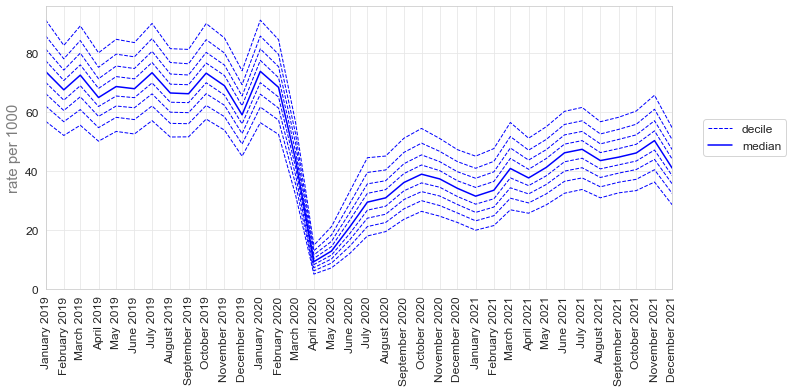

#### Most Common Codes <a href=https://www.opencodelists.org/codelist/opensafely/systolic-blood-pressure-qof/3572b5fb/>(Codelist)</a>

Unnamed: 0,Code,Description_tpp,Description_emis,Proportion of Codes (%)
0,72313002,Systolic arterial pressure,Systolic arterial pressure,96.18
1,413606001,Average home systolic blood pressure,Average home systolic blood pressure,2.54
2,407554009,Sitting systolic blood pressure,Sitting systolic blood pressure,0.42
3,400974009,Standing systolic blood pressure,Standing systolic blood pressure,0.37
4,314449000,NaN,Average 24 hour systolic blood pressure,0.09


Total patients: 27.77M (79.30M events)

In [67]:
systolic_bp_df = generate_sentinel_measure_combined(data_dict_practice, childs_table_dict["systolic_bp"], "systolic_bp", num_patients["systolic_bp"], num_events["systolic_bp"], codelist_link="https://www.opencodelists.org/codelist/opensafely/systolic-blood-pressure-qof/3572b5fb/")

In [68]:
baseline, values, differences = calculate_statistics(systolic_bp_df, '2019-04-01', ['2020-04-01', '2021-04-01'])
display_changes(baseline, values, differences, ['April 2020', 'April 2021'])
classify_changes(differences)

Change in median from April 2019 (65.03) - April 2020 (9.22): (-85.82%)

Change in median from April 2019 (65.03) - April 2021 (37.7): (-42.03%)

Overall classification: **sustained drop**

<a id="qrisk2"></a>
### Cardiovascular Disease 10 year Risk Assessment

The codes used in for this measure are available in <a href="https://www.opencodelists.org/codelist/opensafely/cvd-risk-assessment-score-qof/1adf44a5/">this codelist</a>.

<h3 class="details">What it is </h3>

Rate of cardiovascular disease risk assessments performed per 1000 members of the population.

<h3 class="details">Why it matters</h3>

* Primary prevention of cardiovascular disease is recommended in all people above the age of 40 year, and in particular, in people with clinical conditions such as hypertension and diabetes are at greater risk. To determine an individual's risk of a cardiovascular event such as a myocardial infarction or stroke, an algorithm called QRISK2 is recommended. This estimates the likelihood of a cardiovascular event in the next 10 years, and individuals with a risk of at least 10% should have a discussion with their GP about starting a statin, or blood pressure treatment if they have Stage I hypertension.  
* If patients are not receiving these risk assessments due to the COVID-19 pandemic, these higher risk patients may not be identified and effective preventative treatment may not be commenced.
* Such risk factor assessment generally only occurs in primary care; it would therefore be considered an important marker of the provision and access to basic preventative care. So for example, the risk calculation requires at least a single cholesterol test and blood pressure readings.

          date  level_1   rate  percentile
0   2019-01-01      0.1  3.646          10
1   2019-01-01      0.2  4.604          20
2   2019-01-01      0.3  5.516          30
3   2019-01-01      0.4  6.432          40
4   2019-01-01      0.5  7.360          50
..         ...      ...    ...         ...
319 2021-12-01      0.5  4.950          50
320 2021-12-01      0.6  5.750          60
321 2021-12-01      0.7  6.646          70
322 2021-12-01      0.8  7.762          80
323 2021-12-01      0.9  9.298          90

[324 rows x 4 columns]


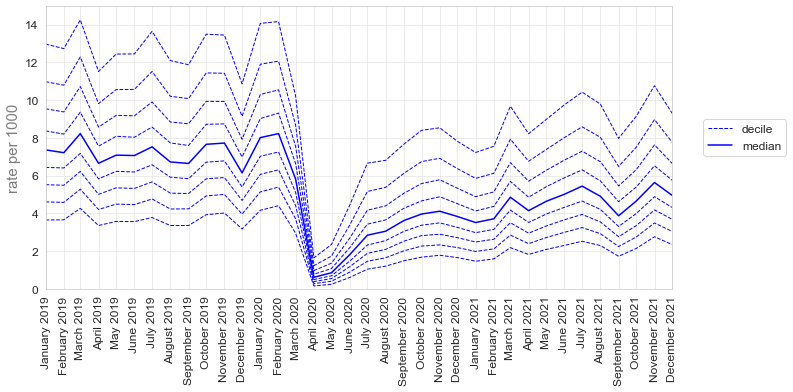

#### Most Common Codes <a href=https://www.opencodelists.org/codelist/opensafely/cvd-risk-assessment-score-qof/1adf44a5/>(Codelist)</a>

Unnamed: 0,Code,Description_tpp,Description_emis,Proportion of Codes (%)
0,718087004,QRISK2 cardiovascular disease 10 year risk score,QRISK2 cardiovascular disease 10 year risk score,96.49
1,763244005,QRISK cardiovascular disease 10 year risk calculator score,QRISK cardiovascular disease 10 year risk calculator score,2.62
2,1085871000000105,QRISK3 cardiovascular disease 10 year risk calculator score,QRISK3 cardiovascular disease 10 year risk calculator score,0.63
3,752451000000100,Cardiovascular disease risk assessment by third party,Cardiovascular disease risk assessment by third party,0.17
4,450759008,NaN,Framingham coronary heart disease 10 year risk score,0.08


Total patients: 7.38M (10.49M events)

In [69]:
qrisk2_df = generate_sentinel_measure_combined(data_dict_practice, childs_table_dict["qrisk2"], "qrisk2", num_patients["qrisk2"], num_events["qrisk2"], codelist_link="https://www.opencodelists.org/codelist/opensafely/cvd-risk-assessment-score-qof/1adf44a5/")

In [70]:
baseline, values, differences = calculate_statistics(qrisk2_df, '2019-04-01', ['2020-04-01', '2021-04-01'])
display_changes(baseline, values, differences, ['April 2020', 'April 2021'])
classify_changes(differences)

Change in median from April 2019 (6.65) - April 2020 (0.61): (-90.83%)

Change in median from April 2019 (6.65) - April 2021 (4.14): (-37.74%)

Overall classification: **sustained drop**

<a id="cholesterol"></a>
### Cholesterol Testing

The codes used in for this measure are available in <a href="https://www.opencodelists.org/codelist/opensafely/cholesterol-tests/09896c09/">this codelist</a>.

<h3 class="details">What it is </h3>

Rate of total cholesterol tests performed per 1000 members of the population.

<h3 class="details">Why it matters</h3>

* Cholesterol tests are used to estimate your risk of cardiovacular disease and to monitor treatment with cholesterol modifying drugs.  You can read more about this test and when it should be used <a href="https://labtestsonline.org.uk/tests/cholesterol-test">here</a>.
* As with most blood tests, there has been debate about the appropriate level of testing but we have presented the information here to inform recovery from COVID-19 in order to “build back better”.

<h3 class="details">Caveats</h3>
Here, we use codes which represent results reported to GPs, so tests requested but not yet reported are not included. This will usually exclude tests requested while a person is in hospital and other settings, like a private clinic.

          date  level_1     rate  percentile
0   2019-01-01      0.1  15.4720          10
1   2019-01-01      0.2  20.6812          20
2   2019-01-01      0.3  23.3100          30
3   2019-01-01      0.4  25.4980          40
4   2019-01-01      0.5  27.4100          50
..         ...      ...      ...         ...
319 2021-12-01      0.5  19.7100          50
320 2021-12-01      0.6  21.4220          60
321 2021-12-01      0.7  23.3140          70
322 2021-12-01      0.8  25.4420          80
323 2021-12-01      0.9  28.0390          90

[324 rows x 4 columns]


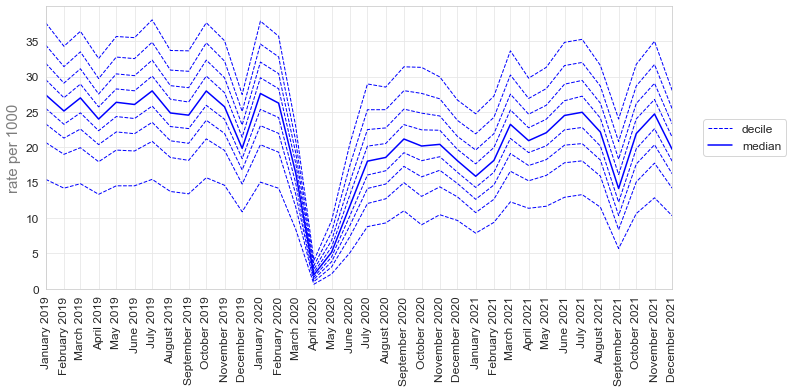

#### Most Common Codes <a href=https://www.opencodelists.org/codelist/opensafely/cholesterol-tests/09896c09/>(Codelist)</a>

Unnamed: 0,Code,Description_tpp,Description_emis,Proportion of Codes (%)
0,1005671000000105,Serum cholesterol level,Serum cholesterol level,97.90
1,1017161000000104,Plasma total cholesterol level,Plasma total cholesterol level,2.00
3,850981000000101,Cholesterol level,Cholesterol level,0.09
2,853681000000104,NaN,Total cholesterol level,0.01
4,365794002,NaN,Finding of serum cholesterol level,0.00


Total patients: 16.82M (32.71M events)

In [71]:
cholesterol_df = generate_sentinel_measure_combined(data_dict_practice, childs_table_dict["cholesterol"], "cholesterol", num_patients["cholesterol"], num_events["cholesterol"], codelist_link="https://www.opencodelists.org/codelist/opensafely/cholesterol-tests/09896c09/")

In [72]:
baseline, values, differences = calculate_statistics(cholesterol_df, '2019-04-01', ['2020-04-01', '2021-04-01'])
display_changes(baseline, values, differences, ['April 2020', 'April 2021'])
classify_changes(differences)

Change in median from April 2019 (23.99) - April 2020 (1.98): (-91.75%)

Change in median from April 2019 (23.99) - April 2021 (20.94): (-12.71%)

Overall classification: **recovery**

<a id="ALT"></a>
### Liver Function Testing - Alanine Transferaminase (ALT)

The codes used in for this measure are available in <a href="https://www.opencodelists.org/codelist/opensafely/alanine-aminotransferase-alt-tests/2298df3e/">this codelist</a>.

<h3 class="details">What it is </h3>

Rate of ALT tests performed per 1000 members of the population.

<h3 class="details">Why it matters</h3>

* ALT tests blood tests are used as a part of Liver Function Testing, a group of tests which detect problems with liver function. You can read more about this test and when it should be used <a href="https://labtestsonline.org.uk/tests/alanine-aminotransferase-alt-test">here</a>.
* As with most blood tests, there has been debate about the appropriate level of testing but we have presented the information here to inform recovery from COVID-19 in order to “build back better”.

<h3 class="details">Caveats</h3>
**In a small number of places, an ALT test may NOT be included within a liver function test.** We use codes which represent results reported to GPs so tests requested but not yet reported are not included. Only tests results returned to GPs are included, which will usually exclude tests requested while a person is in hospital and other settings like a private clinic.

          date  level_1     rate  percentile
0   2019-01-01      0.1  28.8220          10
1   2019-01-01      0.2  32.2860          20
2   2019-01-01      0.3  35.1900          30
3   2019-01-01      0.4  37.9540          40
4   2019-01-01      0.5  40.8500          50
..         ...      ...      ...         ...
319 2021-12-01      0.5  31.1200          50
320 2021-12-01      0.6  33.1984          60
321 2021-12-01      0.7  35.4832          70
322 2021-12-01      0.8  38.1040          80
323 2021-12-01      0.9  41.3304          90

[324 rows x 4 columns]


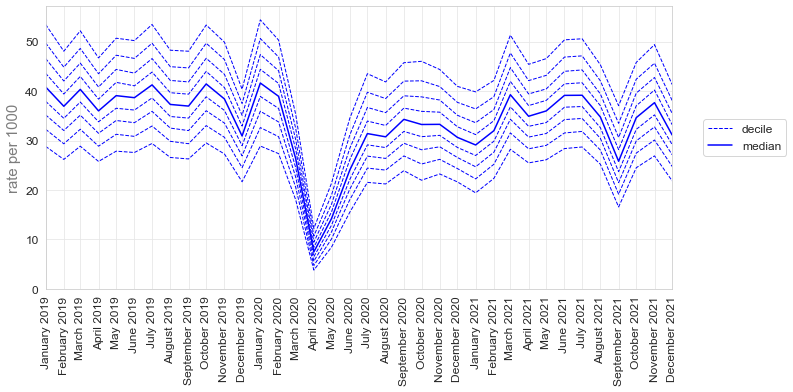

#### Most Common Codes <a href=https://www.opencodelists.org/codelist/opensafely/alanine-aminotransferase-alt-tests/2298df3e/>(Codelist)</a>

Unnamed: 0,Code,Description_tpp,Description_emis,Proportion of Codes (%)
0,1018251000000107,Serum alanine aminotransferase level,Serum alanine aminotransferase level,95.96
1,1013211000000103,Plasma alanine aminotransferase level,Plasma alanine aminotransferase level,3.83
2,250637003,Alanine aminotransferase - blood measurement,Alanine aminotransferase - blood measurement,0.18
5,34608000,Alanine aminotransferase measurement,NaN,0.02
3,201321000000108,NaN,Serum alanine aminotransferase level,0.00


Total patients: 23.36M (54.14M events)

In [73]:
alt_df = generate_sentinel_measure_combined(data_dict_practice, childs_table_dict["alt"], "alt", num_patients["alt"], num_events["alt"], codelist_link="https://www.opencodelists.org/codelist/opensafely/alanine-aminotransferase-alt-tests/2298df3e/")

In [74]:
baseline, values, differences = calculate_statistics(alt_df, '2019-04-01', ['2020-04-01', '2021-04-01'])
display_changes(baseline, values, differences, ['April 2020', 'April 2021'])
classify_changes(differences)

Change in median from April 2019 (36.0) - April 2020 (7.47): (-79.25%)

Change in median from April 2019 (36.0) - April 2021 (34.91): (-3.03%)

Overall classification: **recovery**

<a id="serum_tsh"></a>
### Thyroid Testing

The codes used in for this measure are available in <a href="https://www.opencodelists.org/codelist/opensafely/thyroid-stimulating-hormone-tsh-testing/11a1abeb/">this codelist</a>.

<h3 class="details">What it is </h3>

Rate of thyroid-stimulating hormone (TSH) tests performed per 1000 members of the population.

<h3 class="details">Why it matters</h3>

* Thyroid stimulating hormone (TSH) is a blood test used for diagnosis and monitoring of hypothyroidism and hyperthyroidism. You can read more about this test and <a href="https://labtestsonline.org.uk/tests/thyroid-stimulating-hormone-tsh">when TSH should be used here </a>and NICE have produced guidance on the assessment and <a href="https://www.nice.org.uk/guidance/ng145/chapter/recommendations">management of thyroid disease here</a>. 
* As with most blood tests, there has been debate about the appropriate level of testing but we have presented the information here to inform recovery from COVID-19 in order to “build back better”.

<h3 class="details">Caveats</h3>
Here, we use codes which represent results reported to GPs, so tests requested but not yet reported are not included. This will usually exclude tests requested while a person is in hospital and other settings, like a private clinic.

          date  level_1     rate  percentile
0   2019-01-01      0.1  18.6240          10
1   2019-01-01      0.2  20.5160          20
2   2019-01-01      0.3  22.2440          30
3   2019-01-01      0.4  23.9800          40
4   2019-01-01      0.5  25.7400          50
..         ...      ...      ...         ...
319 2021-12-01      0.5  19.9900          50
320 2021-12-01      0.6  21.4540          60
321 2021-12-01      0.7  23.1136          70
322 2021-12-01      0.8  25.0792          80
323 2021-12-01      0.9  27.7132          90

[324 rows x 4 columns]


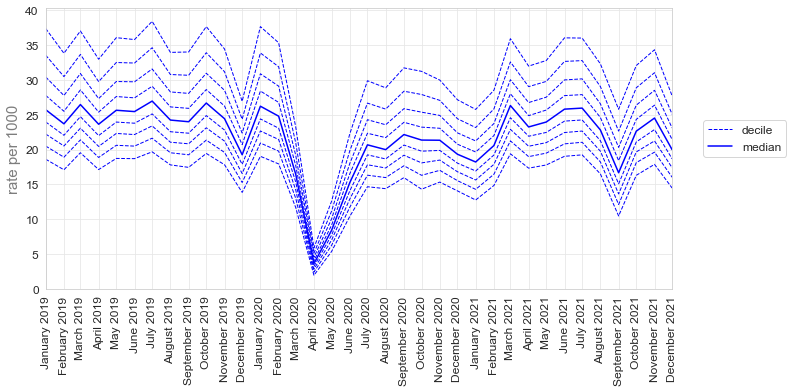

#### Most Common Codes <a href=https://www.opencodelists.org/codelist/opensafely/thyroid-stimulating-hormone-tsh-testing/11a1abeb/>(Codelist)</a>

Unnamed: 0,Code,Description_tpp,Description_emis,Proportion of Codes (%)
0,1022791000000101,Serum thyroid stimulating hormone level,Serum thyroid stimulating hormone level,97.31
1,1022801000000102,Plasma thyroid stimulating hormone level,Plasma thyroid stimulating hormone level,2.54
2,1027151000000105,Thyroid stimulating hormone level,Thyroid stimulating hormone level,0.15
3,61167004,NaN,Thyroid stimulating hormone measurement,0.00
4,313440008,NaN,Measurement of serum thyroid stimulating hormone,0.00


Total patients: 19.36M (36.16M events)

In [75]:
tsh_df = generate_sentinel_measure_combined(data_dict_practice, childs_table_dict["tsh"], "tsh", num_patients["tsh"], num_events["tsh"], codelist_link="https://www.opencodelists.org/codelist/opensafely/thyroid-stimulating-hormone-tsh-testing/11a1abeb/")

In [76]:
baseline, values, differences = calculate_statistics(tsh_df, '2019-04-01', ['2020-04-01', '2021-04-01'])
display_changes(baseline, values, differences, ['April 2020', 'April 2021'])
classify_changes(differences)

Change in median from April 2019 (23.65) - April 2020 (3.62): (-84.69%)

Change in median from April 2019 (23.65) - April 2021 (23.26): (-1.65%)

Overall classification: **recovery**

<a id="rbc_fbc"></a>
### Full Blood Count - Red Blood Cell (RBC) Testing

The codes used in for this measure are available in <a href="https://www.opencodelists.org/codelist/opensafely/red-blood-cell-rbc-tests/576a859e/">this codelist</a>.

<h3 class="details">What it is </h3>

Rate of RBC count tests performed per 1000 members of the population.

<h3 class="details">Why it matters</h3>

* RBC count tests are used as a part of a Full Blood Count, a group of tests which can detect a variety of disorders of the blood, such as anaemia and infection. You can read more about this test and when it should be used <a href="https://labtestsonline.org.uk/tests/red-blood-cell-count">here</a>.
*  As with most blood tests, there has been debate about the appropriate level of testing but we have presented the information here to inform recovery from COVID-19 in order to “build back better”.

<h3 class="details">Caveats</h3>
Here, we use codes which represent results reported to GPs, so tests requested but not yet reported are not included. This will usually exclude tests requested while a person is in hospital and other settings, like a private clinic.

          date  level_1     rate  percentile
0   2019-01-01      0.1  30.3224          10
1   2019-01-01      0.2  33.8572          20
2   2019-01-01      0.3  36.8660          30
3   2019-01-01      0.4  39.6860          40
4   2019-01-01      0.5  42.3500          50
..         ...      ...      ...         ...
319 2021-12-01      0.5  32.8600          50
320 2021-12-01      0.6  35.0248          60
321 2021-12-01      0.7  37.4164          70
322 2021-12-01      0.8  40.0420          80
323 2021-12-01      0.9  43.1700          90

[324 rows x 4 columns]


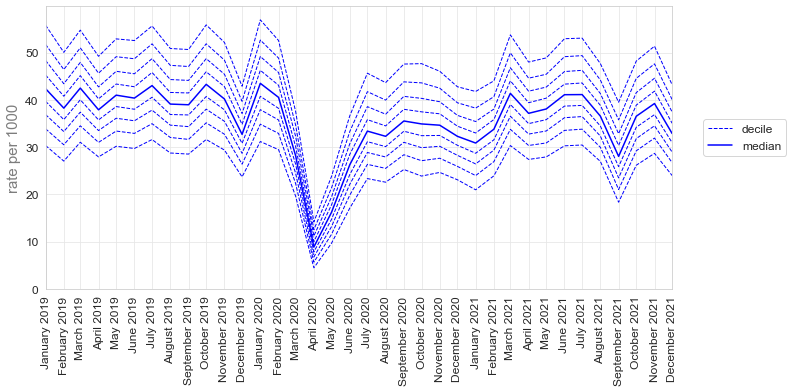

#### Most Common Codes <a href=https://www.opencodelists.org/codelist/opensafely/red-blood-cell-rbc-tests/576a859e/>(Codelist)</a>

Unnamed: 0,Code,Description_tpp,Description_emis,Proportion of Codes (%)
0,1022451000000103,Red blood cell count,Red blood cell count,100.0
1,365625004,NaN,Finding of red blood cell count,0.0
2,14089001,NaN,Red blood cell count,0.0


Total patients: 23.82M (56.95M events)

In [77]:
rbc_df = generate_sentinel_measure_combined(data_dict_practice, childs_table_dict["rbc"], "rbc", num_patients["rbc"], num_events["rbc"], codelist_link="https://www.opencodelists.org/codelist/opensafely/red-blood-cell-rbc-tests/576a859e/")

In [78]:
baseline, values, differences = calculate_statistics(rbc_df, '2019-04-01', ['2020-04-01', '2021-04-01'])
display_changes(baseline, values, differences, ['April 2020', 'April 2021'])
classify_changes(differences)

Change in median from April 2019 (37.88) - April 2020 (8.84): (-76.66%)

Change in median from April 2019 (37.88) - April 2021 (37.13): (-1.98%)

Overall classification: **recovery**

<a id="hba1c"></a>
### Glycated Haemoglobin A1c Level (HbA1c)

The codes used in for this measure are available in <a href="https://www.opencodelists.org/codelist/opensafely/glycated-haemoglobin-hba1c-tests/62358576/">this codelist</a>.

<h3 class="details">What it is </h3>

Rate of HbA1c tests performed per 1000 members of the population.

<h3 class="details">Why it matters</h3>

* HbA1c is a measure of blood glucose levels. It is used to make the diagnosis of type 2 diabetes as well as to monitor the average blood glucose in those with recorded diabetes. It is recommended that everyone with diabetes has HbA1c measured at least twice a year.
* If HbA1c is not been monitored regularly, patients may not be identified as having poor diabetes control, and therefore there is a greater risk of complications.  You can read more about this test and when it should be used <a href="https://labtestsonline.org.uk/tests/hba1c-test">here</a>.
*  As with most blood tests, there has been debate about the appropriate level of testing but we have presented the information here to inform recovery from COVID-19 in order to “build back better”.

<h3 class="details">Caveats</h3>
Here, we use codes which represent results reported to GPs, so tests requested but not yet reported are not included. This will usually exclude tests requested while a person is in hospital and other settings, like a private clinic.

          date  level_1     rate  percentile
0   2019-01-01      0.1  21.2862          10
1   2019-01-01      0.2  24.6360          20
2   2019-01-01      0.3  27.2976          30
3   2019-01-01      0.4  29.6352          40
4   2019-01-01      0.5  32.1600          50
..         ...      ...      ...         ...
319 2021-12-01      0.5  26.0900          50
320 2021-12-01      0.6  27.9460          60
321 2021-12-01      0.7  29.8620          70
322 2021-12-01      0.8  32.0220          80
323 2021-12-01      0.9  34.7662          90

[324 rows x 4 columns]


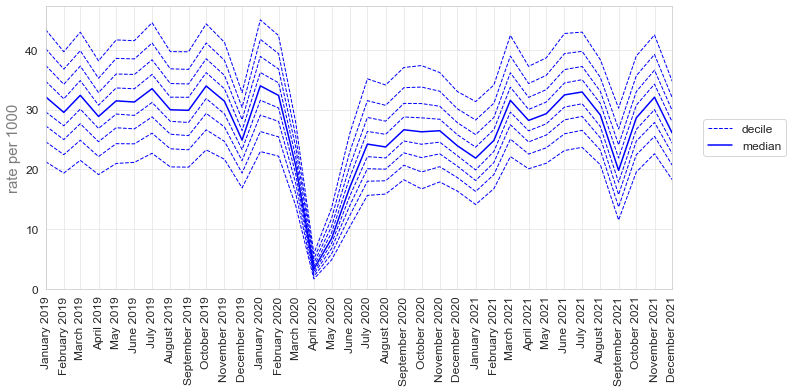

#### Most Common Codes <a href=https://www.opencodelists.org/codelist/opensafely/glycated-haemoglobin-hba1c-tests/62358576/>(Codelist)</a>

Unnamed: 0,Code,Description_tpp,Description_emis,Proportion of Codes (%)
0,999791000000106,Haemoglobin A1c level - International Federation of Clinical Chemistry and Laboratory Medicine standardised,Haemoglobin A1c level - International Federation of Clinical Chemistry and Laboratory Medicine standardised,96.47
1,1003671000000109,Haemoglobin A1c level,Haemoglobin A1c level,3.47
3,43396009,Hemoglobin A1c measurement,Hemoglobin A1c measurement,0.04
2,365845005,Hemoglobin A1C - diabetic control finding,Hemoglobin A1C - diabetic control finding,0.02
4,313835008,NaN,Hemoglobin A1c measurement aligned to the Diabetes Control and Complications Trial,0.00


Total patients: 20.57M (42.80M events)

In [79]:
hba1c_df = generate_sentinel_measure_combined(data_dict_practice, childs_table_dict["hba1c"], "hba1c", num_patients["hba1c"], num_events["hba1c"], codelist_link="https://www.opencodelists.org/codelist/opensafely/glycated-haemoglobin-hba1c-tests/62358576/")

In [80]:
baseline, values, differences = calculate_statistics(hba1c_df, '2019-04-01', ['2020-04-01', '2021-04-01'])
display_changes(baseline, values, differences, ['April 2020', 'April 2021'])
classify_changes(differences)

Change in median from April 2019 (28.86) - April 2020 (3.33): (-88.46%)

Change in median from April 2019 (28.86) - April 2021 (28.2): (-2.29%)

Overall classification: **recovery**

<a id="serum_sodium"></a>
### Renal Function Assessment - Sodium Testing

The codes used in for this measure are available in <a href="https://www.opencodelists.org/codelist/opensafely/sodium-tests-numerical-value/32bff605/">this codelist</a>.

<h3 class="details">What it is </h3>

Rate of sodium blood tests performed per 1000 members of the population.

<h3 class="details">Why it matters</h3>

* Sodium blood test is used to detect the cause and help monitor treatment in persons with dehydration, oedema, or with a variety of other symptoms. It is routinely tested for with other blood electrolytes including those used to detect kidney disease. You can read more about <a href="https://labtestsonline.org.uk/tests/sodium-test">sodium tests and when it should be used here</a>.
*  As with most blood tests, there has been debate about the appropriate level of testing but we have presented the information here to inform recovery from COVID-19 in order to “build back better”.

<h3 class="details">Caveats</h3>
Here, we use codes which represent results reported to GPs, so tests requested but not yet reported are not included. This will usually exclude tests requested while a person is in hospital and other settings, like a private clinic.

          date  level_1     rate  percentile
0   2019-01-01      0.1  36.3342          10
1   2019-01-01      0.2  40.3040          20
2   2019-01-01      0.3  43.6920          30
3   2019-01-01      0.4  46.7960          40
4   2019-01-01      0.5  49.7800          50
..         ...      ...      ...         ...
319 2021-12-01      0.5  37.8500          50
320 2021-12-01      0.6  40.2292          60
321 2021-12-01      0.7  42.7836          70
322 2021-12-01      0.8  45.5740          80
323 2021-12-01      0.9  48.9262          90

[324 rows x 4 columns]


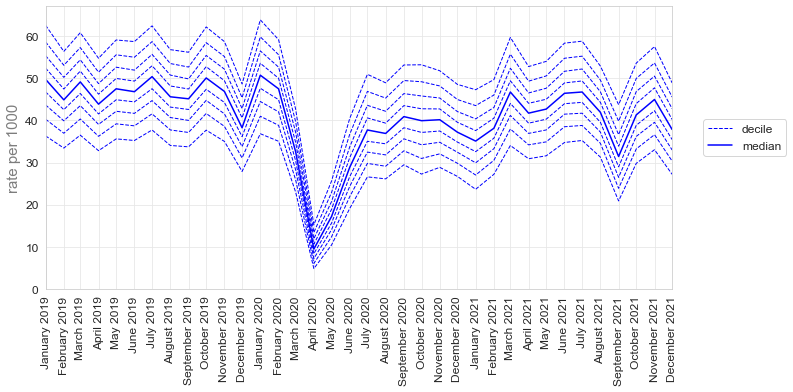

#### Most Common Codes <a href=https://www.opencodelists.org/codelist/opensafely/sodium-tests-numerical-value/32bff605/>(Codelist)</a>

Unnamed: 0,Code,Description_tpp,Description_emis,Proportion of Codes (%)
0,1000661000000107,Serum sodium level,Serum sodium level,97.22
1,1017381000000106,Plasma sodium level,Plasma sodium level,2.78


Total patients: 25.07M (65.99M events)

In [81]:
sodium_df = generate_sentinel_measure_combined(data_dict_practice, childs_table_dict["sodium"], "sodium", num_patients["sodium"], num_events["sodium"], codelist_link="https://www.opencodelists.org/codelist/opensafely/sodium-tests-numerical-value/32bff605/")

In [82]:
baseline, values, differences = calculate_statistics(sodium_df, '2019-04-01', ['2020-04-01', '2021-04-01'])
display_changes(baseline, values, differences, ['April 2020', 'April 2021'])
classify_changes(differences)

Change in median from April 2019 (43.88) - April 2020 (9.45): (-78.46%)

Change in median from April 2019 (43.88) - April 2021 (41.74): (-4.88%)

Overall classification: **recovery**

<a id="asthma"></a>
### Asthma Reviews

The codes used in for this measure are available in <a href="https://www.opencodelists.org/codelist/opensafely/asthma-annual-review-qof/33eeb7da/">this codelist</a>.  QoF recommends a number of codes that can be used by practices as an asthma annual review.  These are all included in our codelist.

<h3 class="details">What it is </h3>

Rate of asthma reviews performed per 1000 members of the population.

<h3 class="details">Why it matters</h3>

* It is recommended that people with asthma receive a review of their condition at least annually, in order to ensure that their asthma is well controlled and that they are using their inhalers correctly.  
* If patients have not received an annual during the time of the pandemic, it is possible that their asthma control may have worsened, leading to greater chance of symptoms and admission.
* The Quality and Outcomes Framework (QoF) recommends a number of codes that can be used by practices as an asthma annual review.  These are all included in our codelist.

          date  level_1    rate  percentile
0   2019-01-01      0.1  3.3040          10
1   2019-01-01      0.2  3.9660          20
2   2019-01-01      0.3  4.5340          30
3   2019-01-01      0.4  5.0480          40
4   2019-01-01      0.5  5.5200          50
..         ...      ...     ...         ...
319 2021-12-01      0.5  3.3900          50
320 2021-12-01      0.6  3.8620          60
321 2021-12-01      0.7  4.3940          70
322 2021-12-01      0.8  5.0540          80
323 2021-12-01      0.9  5.9364          90

[324 rows x 4 columns]


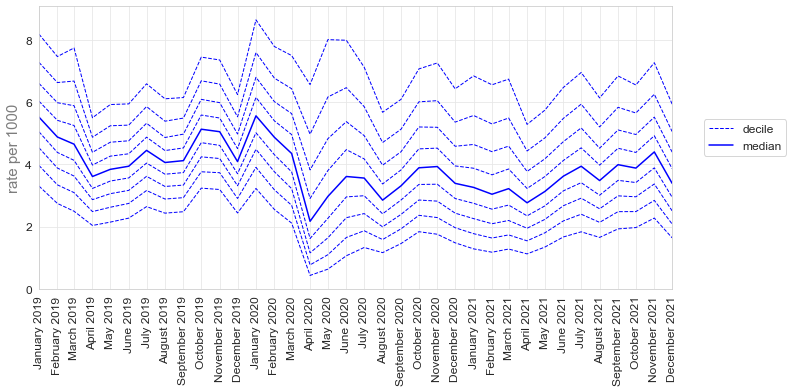

#### Most Common Codes <a href=https://www.opencodelists.org/codelist/opensafely/asthma-annual-review-qof/33eeb7da/>(Codelist)</a>

Unnamed: 0,Code,Description_tpp,Description_emis,Proportion of Codes (%)
0,394700004,Asthma annual review,Asthma annual review,62.10
3,394720003,Asthma medication review,Asthma medication review,12.54
2,401182001,Asthma monitoring by nurse,Asthma monitoring by nurse,8.87
1,270442000,NaN,Asthma monitoring check done,5.89
4,401183006,NaN,Asthma monitoring by doctor,2.73


Total patients: 3.41M (7.15M events)

In [83]:
asthma_df = generate_sentinel_measure_combined(data_dict_practice, childs_table_dict["asthma"], "asthma", num_patients["asthma"], num_events["asthma"], codelist_link="https://www.opencodelists.org/codelist/opensafely/asthma-annual-review-qof/33eeb7da/")

In [84]:
baseline, values, differences = calculate_statistics(asthma_df, '2019-04-01', ['2020-04-01', '2021-04-01'])
display_changes(baseline, values, differences, ['April 2020', 'April 2021'])
classify_changes(differences)

Change in median from April 2019 (3.61) - April 2020 (2.17): (-39.89%)

Change in median from April 2019 (3.61) - April 2021 (2.76): (-23.55%)

Overall classification: **sustained drop**

IndexError: list index out of range

<a id="copd"></a>
### Chronic Obstructive Pulmonary Disease (COPD) Reviews

The codes used in for this measure are available in <a href="https://www.opencodelists.org/codelist/opensafely/chronic-obstructive-pulmonary-disease-copd-review-qof/01cfd170/">this codelist</a>.  

<h3 class="details">What it is </h3>

Rate of COPD reviews (primarily annual reviews, but also includes codes for 6 month and 3 month reviews) performed per 1000 members of the population.

<h3 class="details">Why it matters</h3>

* It is <a href="https://www.nice.org.uk/guidance/ng115/chapter/Recommendations">recommended by NICE</a> that all individuals living with COPD have an annual review, with individuals with very severe (stage 4) COPD being reviewed at least twice a year.
* The purpose of the review is multifaceted, but includes, for example, smoking cessation support, review of symptoms and optimising treatment. The annual COPD review is also a feature of <a href="https://www.england.nhs.uk/wp-content/uploads/2020/09/C0713-202021-General-Medical-Services-GMS-contract-Quality-and-Outcomes-Framework-QOF-Guidance.pdf">QOF</a>, which supports practices to deliver quality care.
* As COPD is a chronic progressive disease with significant morbidity and mortality (especially in more severe cases), a reduction in reviews due to the COVID-19 pandemic could not only lead to worsening disease (and associated complications) but also significant social and economic detriment. 

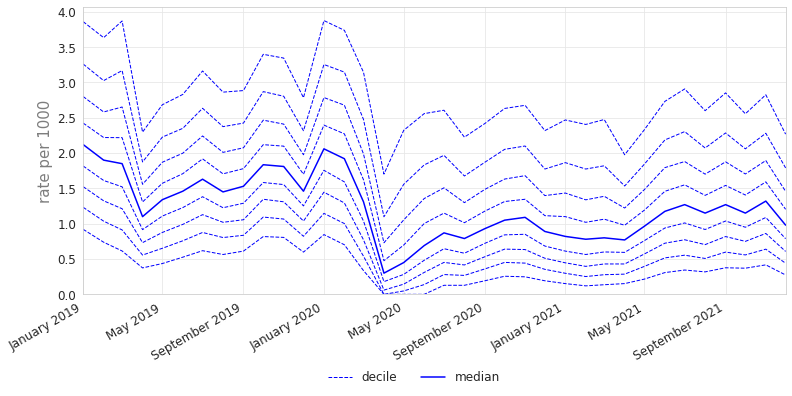

#### Most Common Codes <a href=https://www.opencodelists.org/codelist/opensafely/chronic-obstructive-pulmonary-disease-copd-review-qof/01cfd170/>(Codelist)</a>

Unnamed: 0,Code,Description_tpp,Description_emis,Proportion of Codes (%)
0,394703002,Chronic obstructive pulmonary disease annual review,Chronic obstructive pulmonary disease annual review,96.49
1,760621000000103,Chronic obstructive pulmonary disease 6 monthly review,Chronic obstructive pulmonary disease 6 monthly review,2.08
2,760601000000107,Chronic obstructive pulmonary disease 3 monthly review,Chronic obstructive pulmonary disease 3 monthly review,1.43


Total patients: 1.16M (2.60M events)

In [ ]:
copd_df = generate_sentinel_measure_combined(data_dict_practice, childs_table_dict["copd"], "copd", num_patients["copd"], num_events["copd"], codelist_link="https://www.opencodelists.org/codelist/opensafely/chronic-obstructive-pulmonary-disease-copd-review-qof/01cfd170/")

In [ ]:
baseline, values, differences = calculate_statistics(copd_df, '2019-04-01', ['2020-04-01', '2021-04-01'])
display_changes(baseline, values, differences, ['April 2020', 'April 2021'])
classify_changes(differences)

Change in median from April 2019 (1.1) - April 2020 (0.3): (-72.73%)

Change in median from April 2019 (1.1) - April 2021 (0.77): (-30.0%)

Change in median from April 2019 (1.1) - December 2021 (0.98): (-10.91%)

Overall classification: **sustained drop**

Overall classification: **recovery**

<a id="med_review"></a>
### Medication Reviews

The codes used in for this measure are a combination of codes available in <a href="https://www.opencodelists.org/codelist/opensafely/care-planning-medication-review-simple-reference-set-nhs-digital/61b13c39/">this NHS Digitatil medication planning refset</a> and <a href="https://www.opencodelists.org/codelist/nhsd-primary-care-domain-refsets/medrvw_cod/20200812/">this primary care domain medication review refset</a>.
 
<h3 class="details">What it is </h3>

Rate of recording of codes related to medication reviews performed per 1000 members of the population.

<h3 class="details">Why it matters</h3>

* Many medicines are used long-term and they should be reviewed regularly to ensure they are still appropriate.
* Medication review is a broad term encompassing encompassing a range of types of review, from notes-led review without a patient, to in depth Structured Medication Reviews with multiple appointments and follow-ups. The codelist provided captures all these types of reviews to give an overall picture of medicines reviews.
* NICE have advice on guidance about <a href="https://pathways.nice.org.uk/pathways/medicines-optimisation/medication-review#content">medication reviews here</a> and NHS England has published guidance on <a href="https://www.england.nhs.uk/wp-content/uploads/2020/09/SMR-Spec-Guidance-2020-21-FINAL-.pdf">Structured Medication Reviews</a> which are an intervention aimed at complex or problematic polypharmacy.

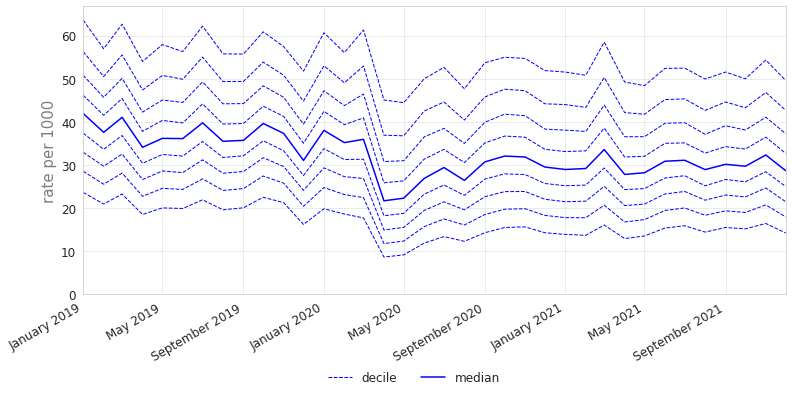

#### Most Common Codes <a href=https://www.opencodelists.org/codelist/opensafely/care-planning-medication-review-simple-reference-set-nhs-digital/61b13c39/>(Codelist)</a>

Unnamed: 0,Code,Description_tpp,Description_emis,Proportion of Codes (%)
3,314530002,Medication review done,Medication review done,34.70
0,182836005,Review of medication,Review of medication,25.41
1,88551000000109,Medication review with patient,Medication review with patient,12.29
2,93311000000106,NaN,Medication review of medical notes,7.05
4,394720003,Asthma medication review,Asthma medication review,2.26


Total patients: 22.47M (58.27M events)

In [ ]:
medication_review_df = generate_sentinel_measure_combined(data_dict_practice, childs_table_dict["medication_review"], "medication_review", num_patients["medication_review"], num_events["medication_review"], codelist_link="https://www.opencodelists.org/codelist/opensafely/care-planning-medication-review-simple-reference-set-nhs-digital/61b13c39/")

In [ ]:
baseline, values, differences = calculate_statistics(medication_review_df, '2019-04-01', ['2020-04-01', '2021-04-01'])
display_changes(baseline, values, differences, ['April 2020', 'April 2021'])
classify_changes(differences)

Change in median from April 2019 (34.1) - April 2020 (21.68): (-36.42%)

Change in median from April 2019 (34.1) - April 2021 (27.8): (-18.48%)

Change in median from April 2019 (34.1) - December 2021 (28.69): (-15.87%)

Overall classification: **sustained drop**

Overall classification: **sustained drop**

In [ ]:
def deciles_chart_subplots(
    df,
    period_column=None,
    column=None,
    title="",
    ylabel="",
    show_outer_percentiles=True,
    show_legend=True,
    ax=None,
):
    """period_column must be dates / datetimes"""
    sns.set_style("whitegrid", {"grid.color": ".9"})
    
    
    df = compute_deciles(df, period_column, column, show_outer_percentiles)
 
    linestyles = {
        "decile": {
            "line": "b--",
            "linewidth": 1,
            "label": "decile",
        },
        "median": {
            "line": "b-",
            "linewidth": 1.5,
            "label": "median",
        },
        "percentile": {
            "line": "b:",
            "linewidth": 0.8,
            "label": "1st-9th, 91st-99th percentile",
        },
    }
    label_seen = []
    for percentile in range(1, 100):  # plot each decile line
        data = df[df["percentile"] == percentile]
        add_label = False

        if percentile == 50:
            style = linestyles["median"]
            add_label = True
        elif show_outer_percentiles and (percentile < 10 or percentile > 90):
            style = linestyles["percentile"]
            if "percentile" not in label_seen:
                label_seen.append("percentile")
                add_label = True
        else:
            style = linestyles["decile"]
            if "decile" not in label_seen:
                label_seen.append("decile")
                add_label = True
        if add_label:
            label = style["label"]
        else:
            label = "_nolegend_"

        ax.plot(
            data[period_column],
            data[column],
            style["line"],
            linewidth=style["linewidth"],
            label=label,
        )
    ax.set_ylabel(ylabel, size=14)
    if title:
        ax.set_title(title, size=20)
    # set ymax across all subplots as largest value across dataset
    ax.set_ylim([0, df[column].max() * 1.05])
    ax.tick_params(labelsize=14)
    ax.set_xlim(
        [df[period_column].min(), df[period_column].max()]
    )  # set x axis range as full date range
    
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%B %Y"))
    if show_legend:
        ax.legend(
            bbox_to_anchor=(0.25, -0.8),  # arbitrary location in axes
            #  specified as (x0, y0, w, h)
            loc=CENTER_LEFT,  # which part of the bounding box should
            #  be placed at bbox_to_anchor
            ncol=1,  # number of columns in the legend
            fontsize=28,
            borderaxespad=0.0,
        )  # padding between the axes and legend
        #  specified in font-size units
    # rotates and right aligns the x labels, and moves the bottom of the
    # axes up to make room for them
    plt.gcf().autofmt_xdate()
    return plt

x = np.arange(0, 6, 1)
y = np.arange(0, 2, 1)

axs_list = [(i, j) for i in x for j in y]
fig, axs = plt.subplots(6, 2, figsize=(15,30), sharex='col')
fig.delaxes(axs[5, 1])

sentinel_measures = ["qrisk2", "asthma", "copd", "sodium", "cholesterol", "alt", "tsh", "rbc", 'hba1c', 'systolic_bp', 'medication_review']

titles = ['Cardiovascular disease risk assessment', 'Asthma review', 'COPD review', 'Renal assessment', 'Cholesterol testing', 'Liver function testing', 'Thyroid testing', 'Full blood count testing', 'Glycated haemoglobin testing', 'Blood pressure monitoring', 'Medication review']

for x, measure in enumerate(sentinel_measures):
    
    df = data_dict_practice[measure]
    
    
    
    if axs_list[x] == (4, 1):
        show_legend = True
    
    else:
        show_legend=False
        
        
       
    deciles_chart_subplots(df,
        period_column='date',
        column='rate',
        title=titles[x],
        ylabel="Rate per 1000",
        show_outer_percentiles=False,
        show_legend=show_legend,
        ax=axs[axs_list[x]])
 
fig.savefig('../backend_outputs/sentinel_measures_subplots.png')
plt.close()